In [1]:
import math
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr
import seaborn as sns
from matplotlib.pyplot import figure

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [4]:
df = pd.read_csv('C:/Users/xhuli/Documents/GIT_REPOS/DM2Project/datatraining.txt')

In [5]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


We decided to add an attribute day_of_week because we are treating room occupancy of office that seem closed in Saturday and Sunday

In [6]:
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df.loc[df['day_of_week'] <= 4, 'Weekend'] = 0
df.loc[df['day_of_week'] > 4, 'Weekend'] = 1
df["working_hours"]=df["date"].apply(lambda x: 1 if ((x.hour>7) & (x.hour<18)) else 0)
del df['day_of_week']

In [7]:
df=df.set_index('date')

In [8]:
class_name = 'Occupancy'

In [9]:
df['Weekend'] = df['Weekend'].astype('category')

In [10]:
df['Occupancy'] = df['Occupancy'].astype('category')

In [11]:
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Weekend,working_hours
date,,,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,0.0,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,0.0,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,0.0,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,0.0,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,0.0,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8143 entries, 2015-02-04 17:51:00 to 2015-02-10 09:33:00
Data columns (total 8 columns):
Temperature      8143 non-null float64
Humidity         8143 non-null float64
Light            8143 non-null float64
CO2              8143 non-null float64
HumidityRatio    8143 non-null float64
Occupancy        8143 non-null category
Weekend          8143 non-null category
working_hours    8143 non-null int64
dtypes: category(2), float64(5), int64(1)
memory usage: 461.4 KB


In [13]:
df.isnull().sum()

Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
Weekend          0
working_hours    0
dtype: int64

In [14]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,working_hours
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.380327
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.485497
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,1.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


In [15]:
df.corr()

,Temperature,Humidity,Light,CO2,HumidityRatio,working_hours
Temperature,1.000000,-0.141759,0.649942,0.559894,0.151762,0.481240
Humidity,-0.141759,1.000000,0.037828,0.439023,0.955198,0.020984
Light,0.649942,0.037828,1.000000,0.664022,0.230420,0.747421
CO2,0.559894,0.439023,0.664022,1.000000,0.626556,0.458373
HumidityRatio,0.151762,0.955198,0.230420,0.626556,1.000000,0.155902
working_hours,0.481240,0.020984,0.747421,0.458373,0.155902,1.000000


HumidityRatio e Humidity hanno un'alta correlazione quindi possiamo eliminare uno dei due attributi.

In [16]:
del df['HumidityRatio']

In [17]:
df.to_csv ('C:/Users/xhuli/Documents/GIT_REPOS/DM2Project/trainingDataAfterDataUnderstanding.csv', index=None, header=True) #Don't forget to add '.csv' at the end of the path

In [18]:
class_name = 'Occupancy'
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


,Temperature,Humidity,Light,CO2,working_hours,Weekend=0.0,Weekend=1.0,Occupancy
date,,,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,1,1,0,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,1,1,0,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,1,1,0,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,1,1,0,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,1,1,0,1


In [19]:
df['Occupancy'].plot(figsize=(20,5))
plt.xlabel("")
plt.grid(True)
plt.show()

TypeError: no numeric data to plot

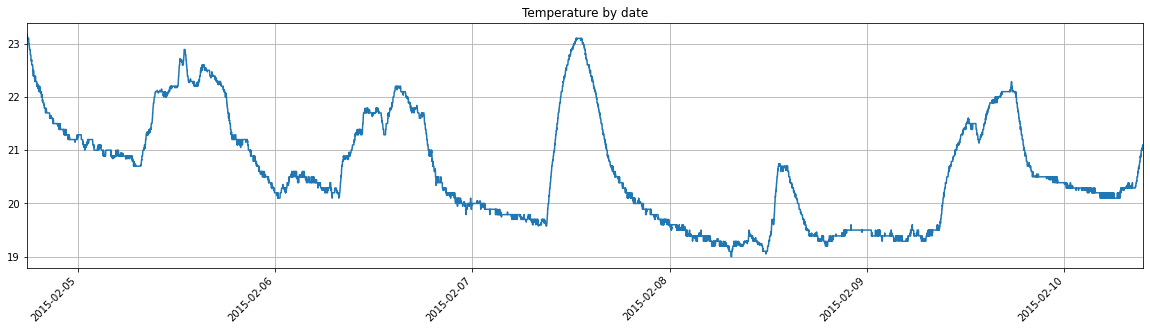

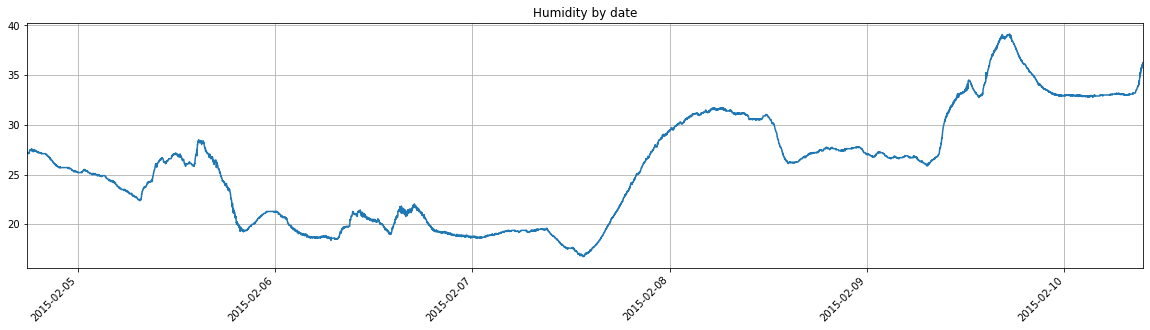

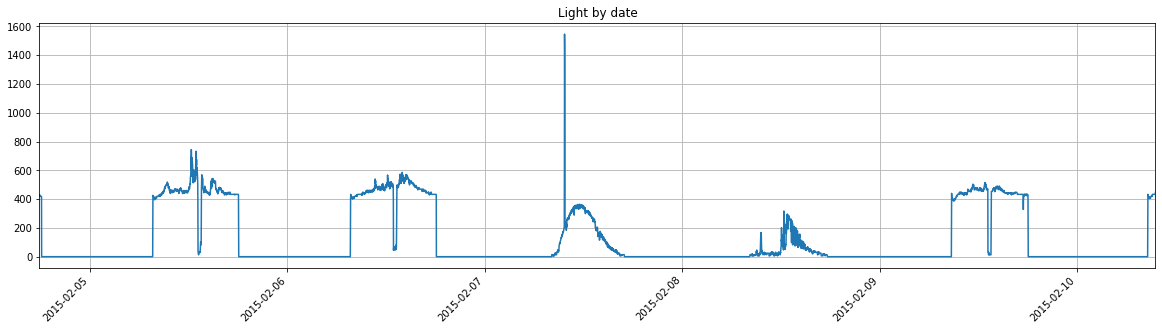

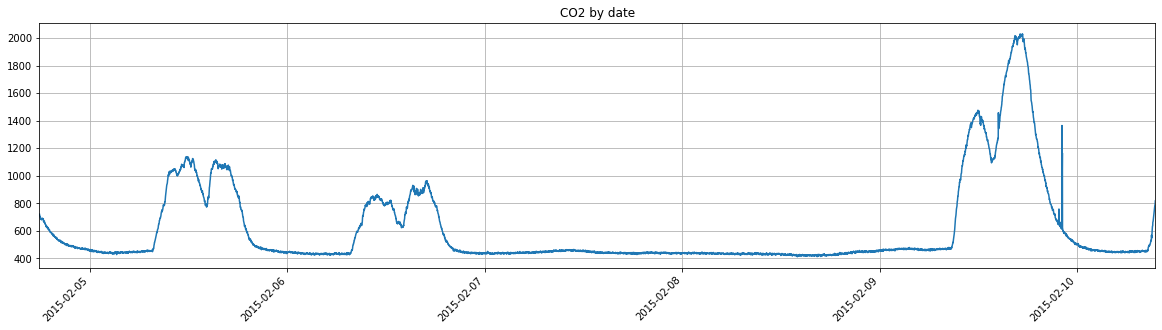

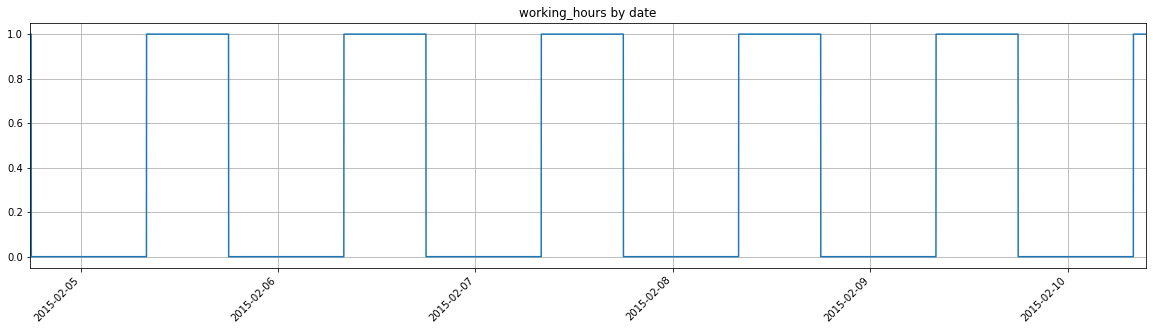

In [20]:
for column in numeric_columns:
    plt.title(column + " by date")
    df[column].plot(figsize=(20,5))
    plt.xticks(rotation='45')
    plt.xlabel("")
    plt.grid(True)
    plt.show()

TODO fare grafici rispetto all'ora

In [21]:
dfp = df.pivot(columns='Occupancy', values="Temperature")

In [22]:
dfp

Occupancy,0,1
date,,
2015-02-04 17:51:00,NaN,23.18
2015-02-04 17:51:59,NaN,23.15
2015-02-04 17:53:00,NaN,23.15
2015-02-04 17:54:00,NaN,23.15
2015-02-04 17:55:00,NaN,23.10
...,...,...
2015-02-10 09:29:00,NaN,21.05
2015-02-10 09:29:59,NaN,21.05
2015-02-10 09:30:59,NaN,21.10


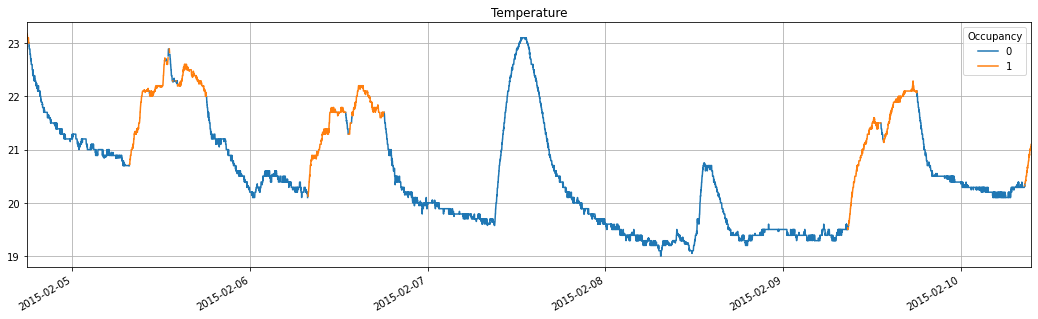

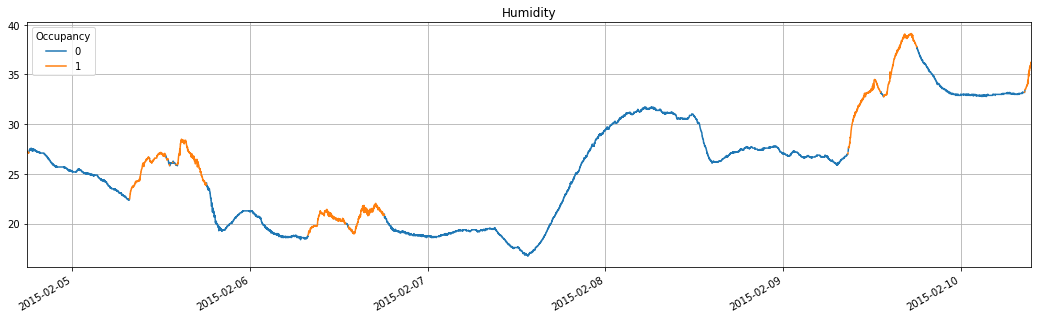

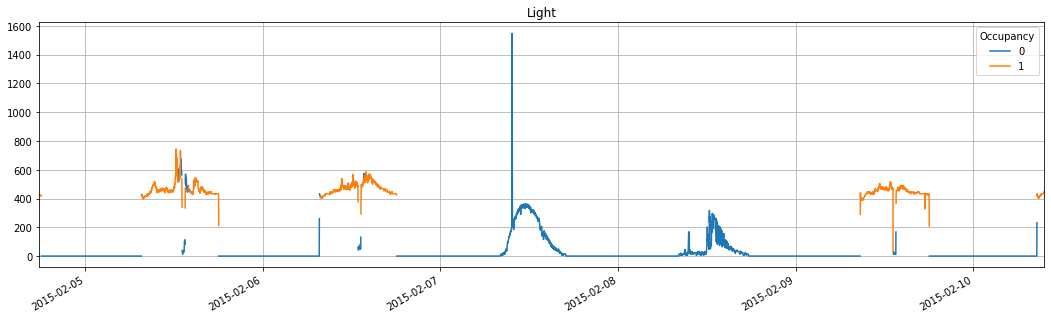

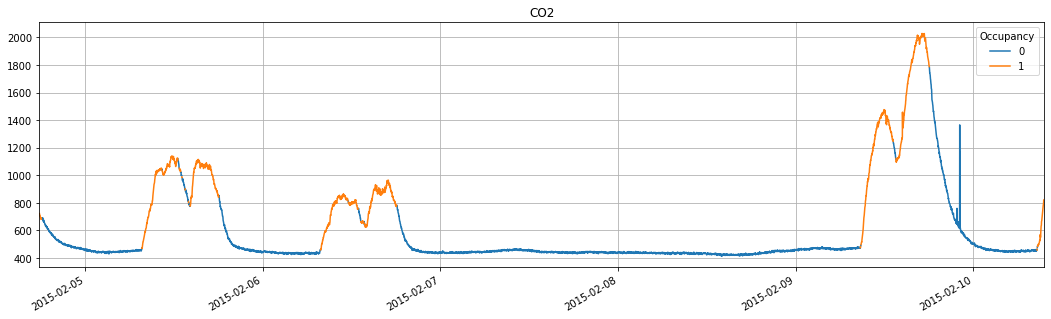

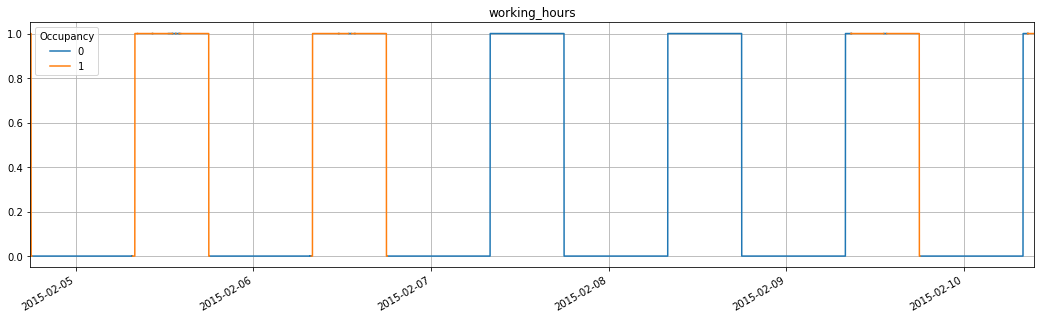

In [24]:
for column in numeric_columns:
    dfp = df.pivot(columns='Occupancy', values=column)
    dfp.plot(title=column, figsize=(18,5))
    plt.xlabel("")
    plt.grid(True)
    plt.show()

02/08, 02/09 sono rispettivamente sabato e domenica. Probabilmente gli uffici sono chiusi in quei due giorni.

In [25]:
df_no_weekend=df.drop(df.loc['2015-02-07':'2015-02-08'].index)

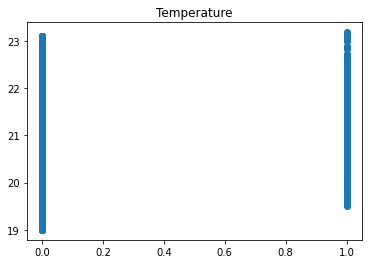

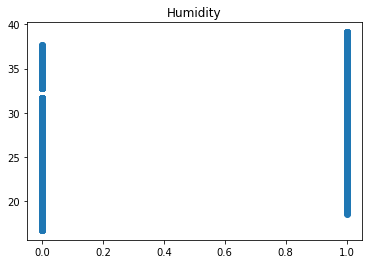

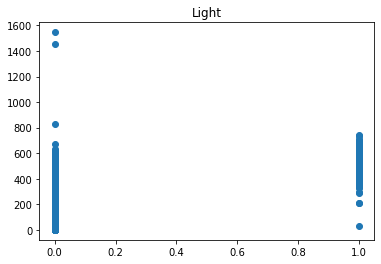

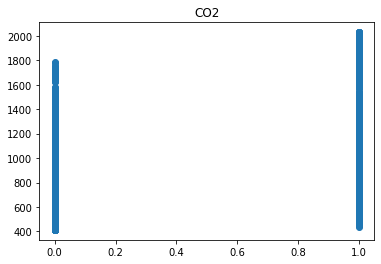

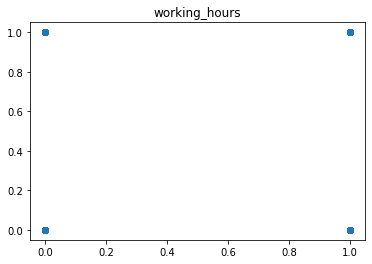

In [26]:
for column in numeric_columns:
    plt.scatter(df['Occupancy'],df[column])
    plt.title(column)
    plt.xlabel("")
    plt.show()

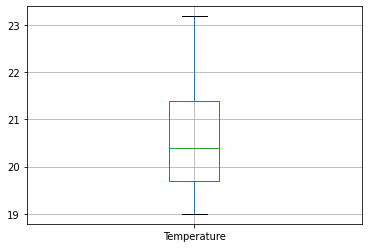

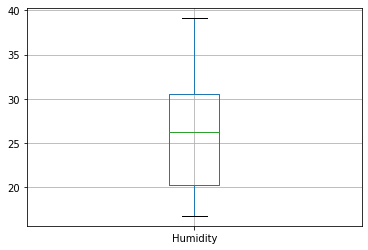

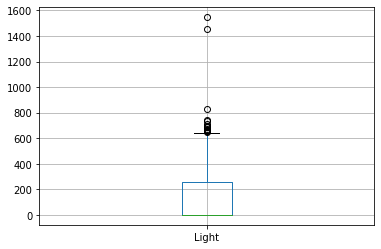

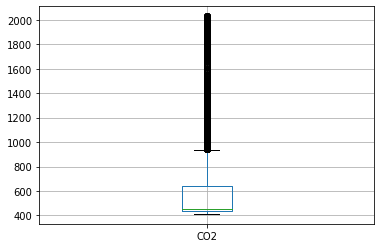

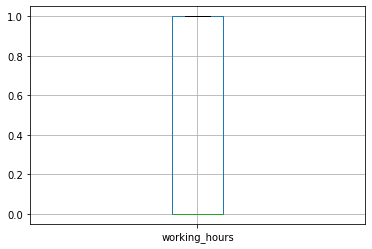

In [27]:
for column in numeric_columns:
    df.boxplot(column=[column])
    plt.show()